# Forecasting with `sktime`

**OBJECTIVES**

- Basic forecasting workflow with `sktime` library
- Exponential Smoothing models
- Holt Winters Model
- Autoregression
- ARIMA Models

Starting from our last notebook, today we will cover additional forecasting models and further use `sktime` to implement time series forecasting models.  We will use data that is already prepared as we discussed -- datetime index sorted in time.

### Grid Searching a Pipeline

The example below demonstrates gridsearching elements of a pipeline.  How does this work?

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_openml
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [3]:
set_config(transform_output='pandas')

In [4]:
survey = fetch_openml(data_id=534, as_frame=True)

In [5]:
X = survey.data
y = survey.target

In [6]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,35,White,Other,Other,Married


In [7]:
cat_cols = X.select_dtypes('category').columns.tolist()

In [8]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')
transformer = make_column_transformer((ohe, cat_cols), remainder = 'passthrough',
                                     verbose_feature_names_out=False)

In [9]:
forest = RandomForestRegressor()

In [10]:
pipe = Pipeline([('transformer', transformer), ('model', forest)])

In [11]:
#what is happening here?
params = {'model__n_estimators': [10, 100, 400],
          'transformer__remainder': ['passthrough', PolynomialFeatures(interaction_only=True)]}

In [12]:
grid = GridSearchCV(pipe, param_grid=params)

In [13]:
grid.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['SOUTH',
                                                                          'SEX',
                                                                          'UNION',
                                                                          'RACE',
                                                                          'OCCUPATION',
                                                                          'SECTOR',
                                                                          'MARR'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', RandomForestRegressor())]),
             param_grid={'model__n_estimators': [10, 100, 400],
                         'transformer__remainder': ['passthrough',
                                                    PolynomialFeatures(interaction_only=True)]})

In [14]:
grid.best_params_

{'model__n_estimators': 400,
 'transformer__remainder': PolynomialFeatures(interaction_only=True)}

In [15]:
grid.score(X, y)

0.861165775854394

**Feature Importances**

The `RandomForestRegressor` has `.feature_importances_` determined by the use of a feature in splitting.  Below these are displayed as a DataFrame.

In [ ]:
steps = grid.best_estimator_.named_steps

In [693]:
pd.DataFrame(steps['model'].feature_importances_, 
             index = steps['transformer'].get_feature_names_out(),
            columns = ['feature importance'])\
            .sort_values(by = 'feature importance', 
            ascending = False)

,feature importance
AGE,0.229380
EDUCATION,0.224568
EXPERIENCE,0.143771
OCCUPATION_Management,0.055088
SEX_male,0.034525
SEX_female,0.032086
UNION_member,0.029695
UNION_not_member,0.025231
OCCUPATION_Professional,0.024033
OCCUPATION_Clerical,0.023762


### `sktime`

In [61]:
#!pip install sktime[all_extras]

In [465]:
import sktime as skt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [467]:
import sktime as skt

In [469]:
from sktime.datasets import load_lynx
from sktime.utils.plotting import plot_correlations, plot_series

In [471]:
lynx = load_lynx()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Number of Lynx trappings'>)

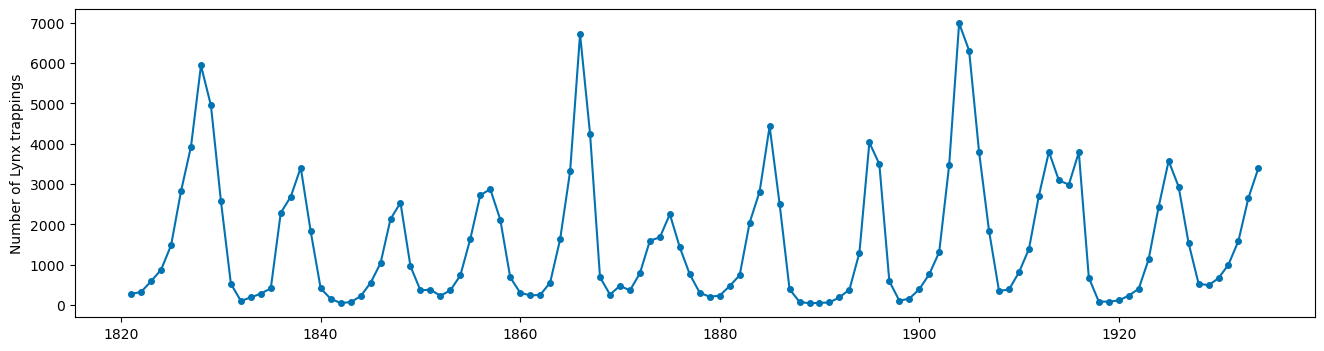

In [477]:
plot_series(lynx)

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='Number of Lynx trappings'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

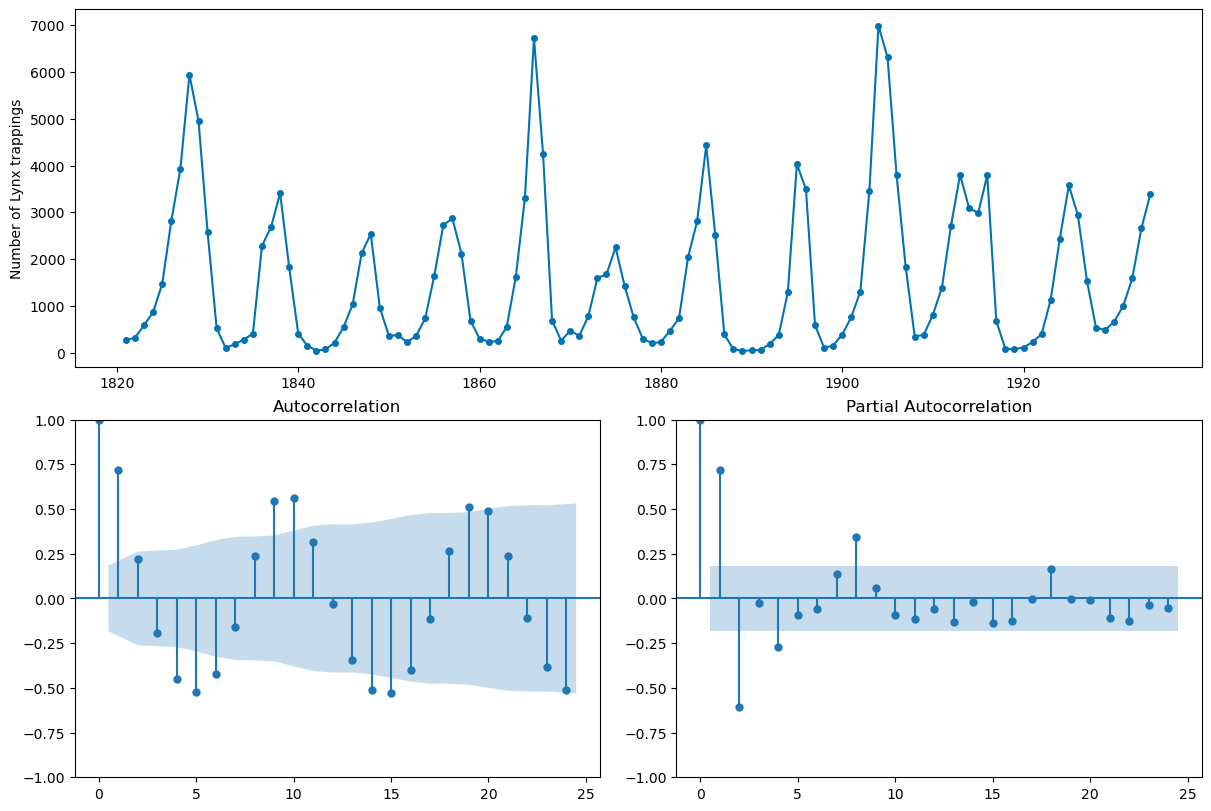

In [475]:
plot_correlations(lynx);

### Forecasting with `sktime`

In [73]:
from sktime.datasets import load_airline

In [76]:
airline = load_airline()

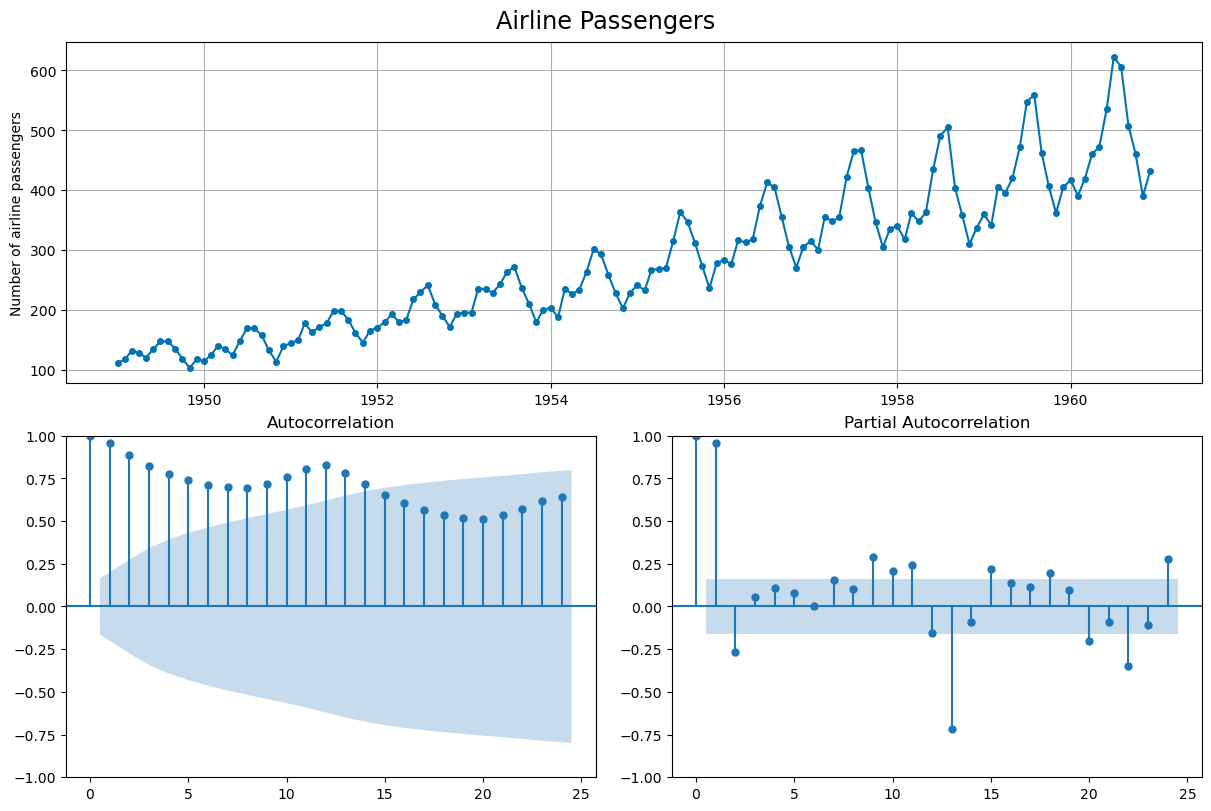

In [485]:
_, ax = plot_correlations(airline, suptitle = 'Airline Passengers')
ax[0].grid()

In [80]:
from sktime.split import temporal_train_test_split

In [82]:
X_train, X_test = temporal_train_test_split(airline)

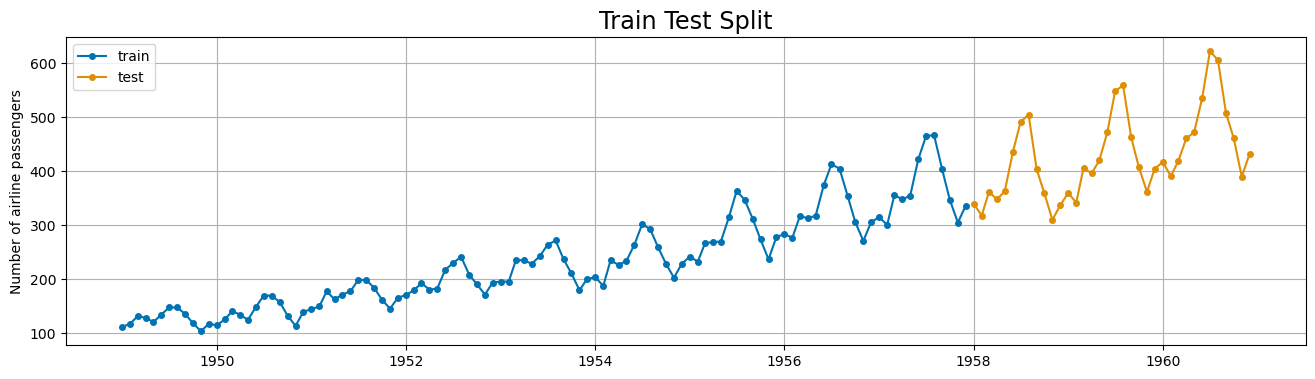

In [489]:
plot_series(X_train, X_test, labels = ['train', 'test'], title = 'Train Test Split')
plt.grid();

### Baseline Model

The `NaiveForecaster` provides multiple strategies for baseline predicitions.  What does `stragey = 'drift'` do?  Plot the predictions along with the train and test data adding appropriate labels.  

In [89]:
from sktime.forecasting.naive import NaiveForecaster

In [137]:
#number of time steps to forecast
fh = np.arange(len(X_test))

In [491]:
#instantiate
forecaster = NaiveForecaster(strategy = 'drift')
#fit model
forecaster.fit(X_train)
#predict for horizon
yhat = forecaster.predict(fh)

In [ ]:
#plot the predictions using plot_series


### Evaluating predictions

`sktime` implements many evaluation metrics.  Below, the `MeanAbsolutePercentageError` class is instantiated and used to evaluated the naive baseline.  Per usual, lower is better.

In [206]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

In [208]:
mae = MeanAbsolutePercentageError()

In [210]:
mae(X_test, yhat)

0.13496141966254382

### Exponential Smoothing

The weighted moving average model -- very basic and simple; predicts the same value over and over.

In [427]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [429]:
#instantiate
exp = ''

In [494]:
#fit the model


In [496]:
#predict
exp_preds = ''

In [437]:
#evaluate
mae(X_test, exp_preds)

0.20139979986833778

In [498]:
#plot the series


### Holt Winters Model

Triple Exponential Smoothing where trend and seasonality are considered.  Below, a holt winters model is implemented.

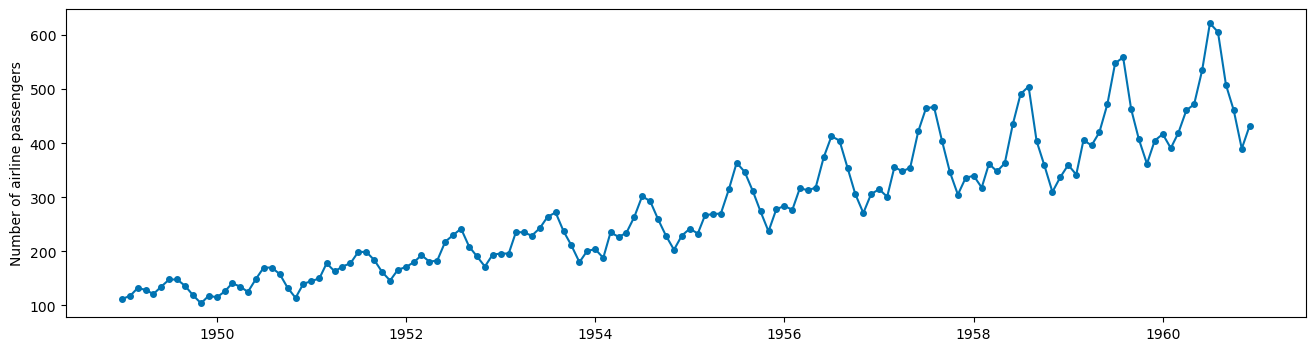

In [500]:
#what kind of seasonality?
plot_series(airline);

- Need trend, seasonality, and seasonal periods

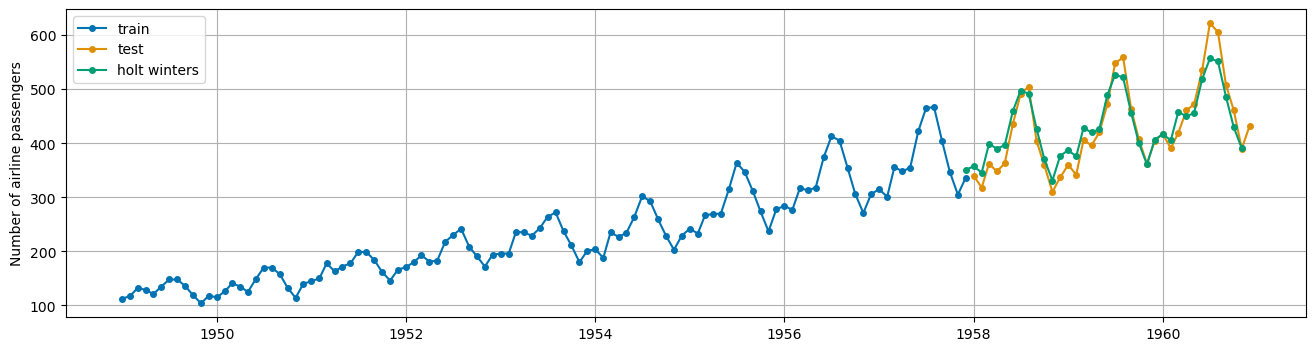

In [514]:
hw = ExponentialSmoothing()
hw.fit(X_train)
hw_preds = hw.predict(fh)
plot_series(X_train, X_test, hw_preds, 
            labels = ['train', 'test', 'holt winters'],
           )
plt.grid();

In [235]:
mae(X_test, hw_preds)

0.09387460045985613

**QUESTION**: What kind of seasonality should we use here -- additive or multiplicative?  Why?

### Stationarity and Differencing

Regression models in time series will also have assumptions about the data, namely that the data we model is **stationary**.  Stationary data has constant mean and variance -- thus trends and seasonality are not a part of stationary time series.

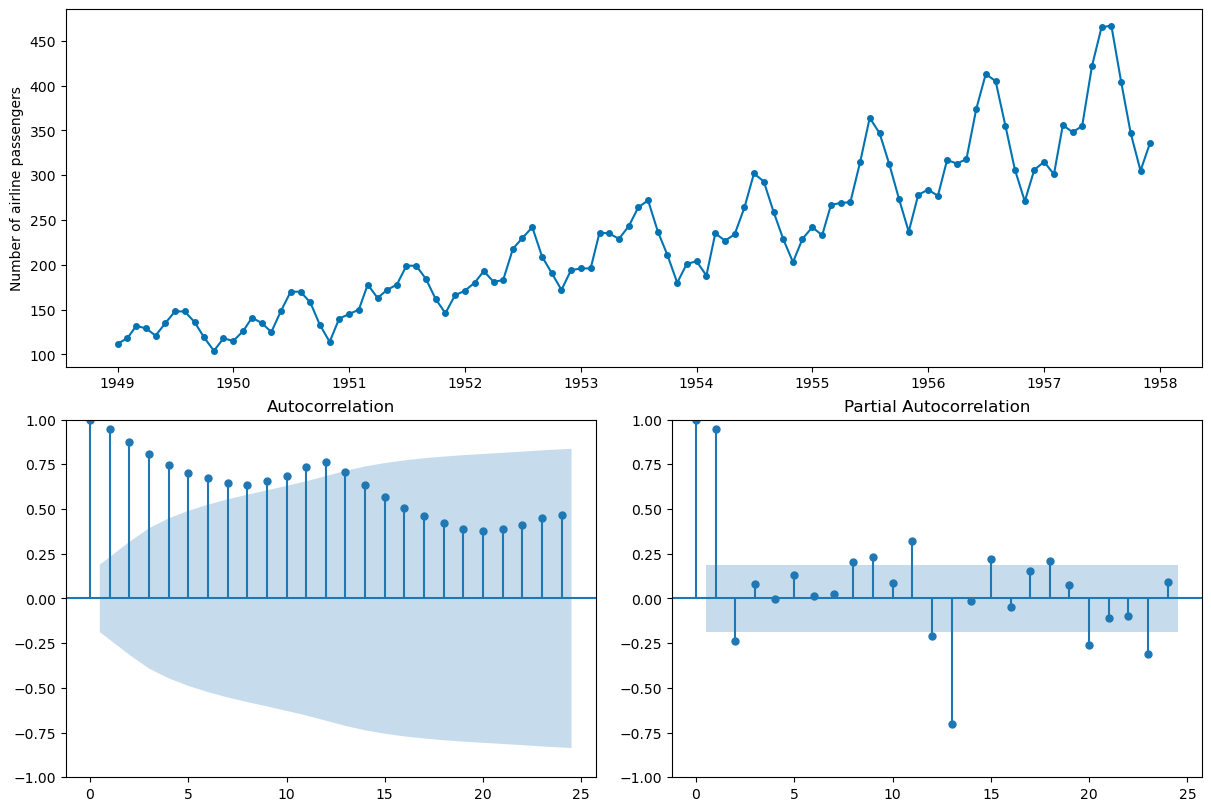

In [506]:
plot_correlations(X_train);

### Differencing the Data

One way to remove the trend is to difference the data.  Compare the resulting autocorrelation plot to the undifferenced data.

In [449]:
X_train.diff(1).head()

1949-01     NaN
1949-02     6.0
1949-03    14.0
1949-04    -3.0
1949-05    -8.0
Freq: M, Name: Number of airline passengers, dtype: float64

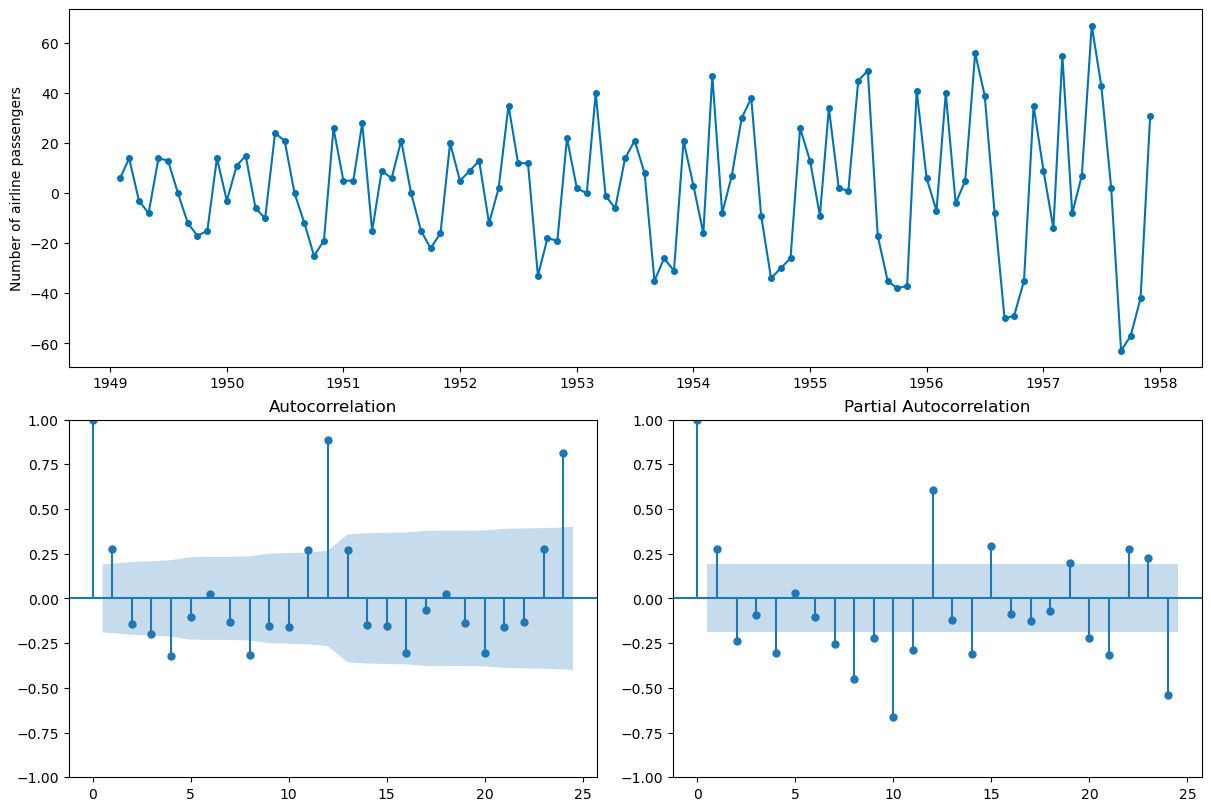

In [451]:
plot_correlations(X_train.diff(1).dropna());

**QUESTION**

- What is the difference between the autocorrelation in the original data and differenced data?


### AutoRegression

Similar to regression however the regression is on previous time steps or "lags".

$$AR(p) = c + \theta_1 y_{t - 1} + \theta_2 y_{t - 2} + ... + \theta_n y_{t - p} + \epsilon$$

In [313]:
from sktime.forecasting.auto_reg import AutoREG

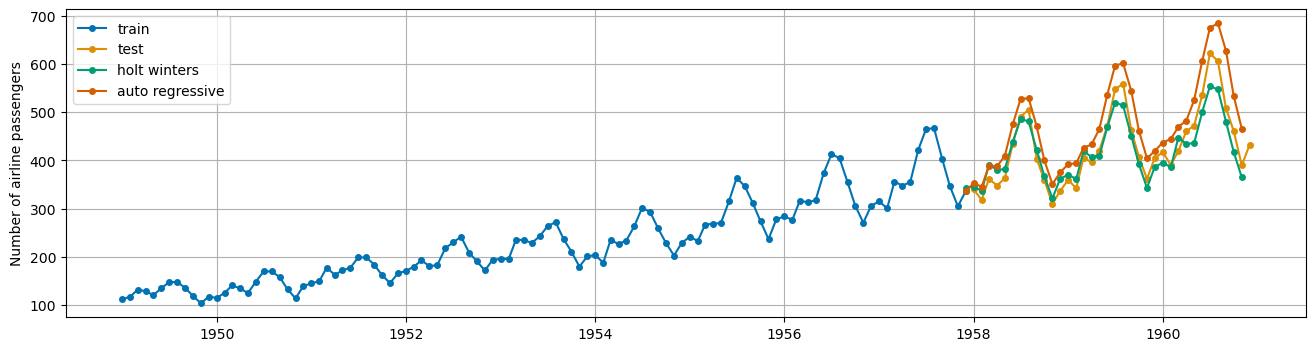

In [509]:
ar = AutoREG(lags = 12)
ar.fit(X_train)
ar_preds = ar.predict(fh)
plot_series(X_train, X_test, hw_preds, ar_preds,
            labels = ['train', 'test', 'holt winters', 'auto regressive'],
           )
plt.grid();

In [323]:
ar.get_fitted_params()

{'aic': 757.542243633855,
 'aicc': 762.7274288190403,
 'bic': 793.4431183144047,
 'hqic': 772.0539637923447,
 'const': 2.9873776849433797,
 'Number of airline passengers.L1': 0.44024802821861964,
 'Number of airline passengers.L2': -0.24712930495045438,
 'Number of airline passengers.L3': 0.19596577672853754,
 'Number of airline passengers.L4': -0.23300070381218363,
 'Number of airline passengers.L5': 0.2307885835405692,
 'Number of airline passengers.L6': -0.17243176175515784,
 'Number of airline passengers.L7': 0.14303113614100504,
 'Number of airline passengers.L8': -0.22605487868090735,
 'Number of airline passengers.L9': 0.22902051756885133,
 'Number of airline passengers.L10': -0.2242183998876448,
 'Number of airline passengers.L11': 0.3190313152823776,
 'Number of airline passengers.L12': 0.6340912733182218}

In [511]:
mae(X_test, ar_preds)

0.12018065547863704

#### Example: Shampoo Sales

In [518]:
from sktime.datasets import load_shampoo_sales

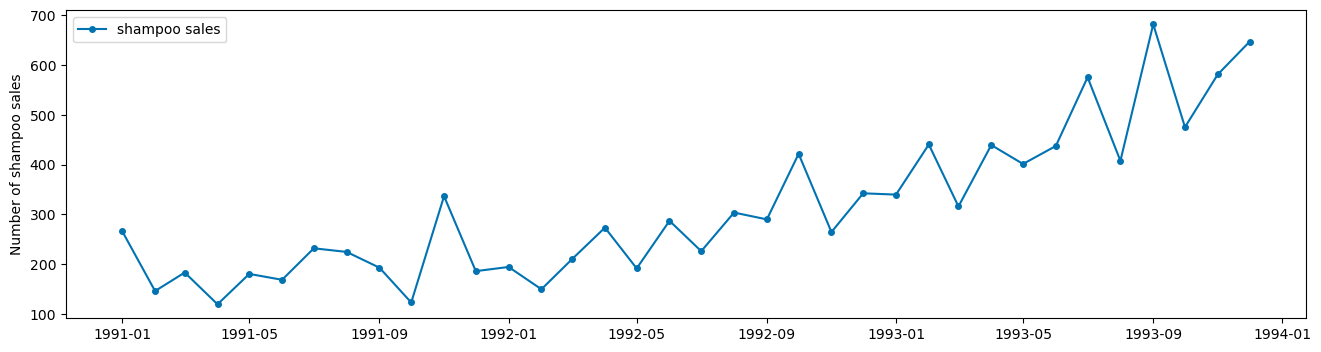

In [520]:
shampoo = load_shampoo_sales()
plot_series(shampoo, labels = ['shampoo sales']);

**PROBLEM**

Split the data into train and test sets to build a Holt Winters model and AutoRegressive model.  Compare performance on the test data and plot the resulting predictions using `plot_series` with appropriate labels.

### ARIMA models

- `AR`: Autoregressive component as above
- `MA`: Moving average of errors

$$MA(q) = c + \epsilon_t + \theta_1 \epsilon_{t+1} + ... + \theta_q \epsilon_{t - q}$$
- `ARIMA`: Autoregressive integrated moving average

$$ARIMA(p, q, d) = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t - p} + \theta_1 \epsilon_{t-1} + ... + \epsilon_{t - q} + \epsilon_t$$

- $p$: order of autoregressive component
- $q$: order of moving average component
- $d$: order of differences of series

- `ARIMA((p, q, d), (P, Q, D, M))`: ARIMA model with seasonal components and backshift operations on P, Q, D (for example (1, 1, 1, 12) uses 12 timesteps as a season and will consider 1 backshift on P, Q, and D).

In [297]:
from sktime.forecasting.arima import ARIMA

In [455]:
arima = ARIMA(order = (1, 1, 1), seasonal_order=(1, 1, 1, 12))

In [457]:
arima.fit(X_train)

ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

In [461]:
arima_preds = arima.predict(fh)

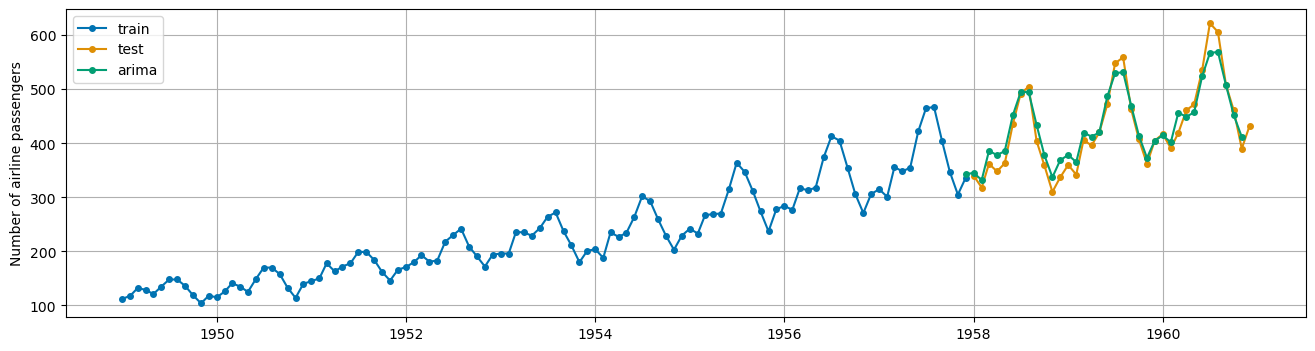

In [523]:
plot_series(X_train, X_test, arima_preds,
            labels = ['train', 'test', 'arima'],
           )
plt.grid();

**Problem**

Return to the shampoo sales data and use an `AutoARIMA` model to fit the data.  This model will automatically learn the parameters for $p, q, d$.